In [279]:
#================================================
# Define serie aleatoria de retornos
#================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

nYears = 15
vol = 8/100
CDI = 6/100
sharpe = 0.7
nFundo = 10
nNoise = 90

# Dados diario
sigma = vol/np.sqrt(252)
cdiDia = np.log(1+CDI)/252
mu = cdiDia
muAlpha = cdiDia + sharpe*vol/252
nDays = nYears * 252
nTot = nFundo + nNoise

# Serie
np.random.seed(1)
retTs = np.random.normal(muAlpha, sigma, nFundo*nDays)
retTs = np.reshape(retTs,(nDays,nFundo))
retTs = np.append(retTs,np.random.normal(mu, sigma, nNoise*nDays).reshape((nDays,nNoise)),axis=1)

# Janelas de retorno que vamos usar
nWin = [125,504,1008]


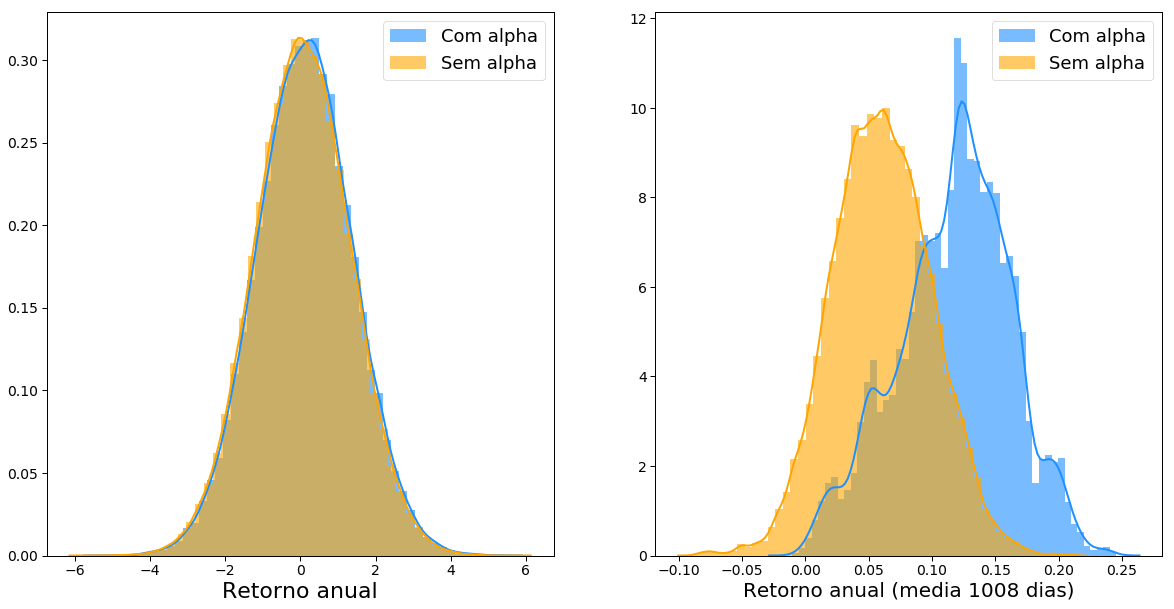

In [301]:
#================================================
# Na media fundos bons são melhores que fundos ruins, 
#================================================

x1 = pd.DataFrame(retTs[:,:nFundo].reshape(nFundo*nDays,1)*252)
x2 = pd.DataFrame(retTs[:,nFundo:].reshape(nNoise*nDays,1)*252)

xBons = []
xNoise = []

winAux = nWin[2]

for i in range(winAux,nDays):
    range_i = range(i-winAux,i)
    meanAux = np.mean(retTs[range_i,],axis=0)
    xBons.extend(meanAux[:nFundo]*252)
    xNoise.extend(meanAux[nFundo:]*252)

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["axes.labelsize"] = 30
plt.rcParams["font.size"] = 30

plt.subplot(1,2,1)
sns.distplot(x1, color="dodgerblue", label="Com alpha", **kwargs)
sns.distplot(x2, color="orange", label="Sem alpha", **kwargs)
plt.xlabel('Retorno anual', fontsize=22)
plt.legend(fontsize=18);
plt.tick_params(labelsize=14);
plt.subplot(1,2,2)
sns.distplot(xBons, color="dodgerblue", label="Com alpha", **kwargs)
sns.distplot(xNoise, color="orange", label="Sem alpha", **kwargs)
plt.xlabel('Retorno anual (media '+str(winAux) + ' dias)', fontsize=20)
plt.legend(fontsize=18);
plt.tick_params(labelsize=14);

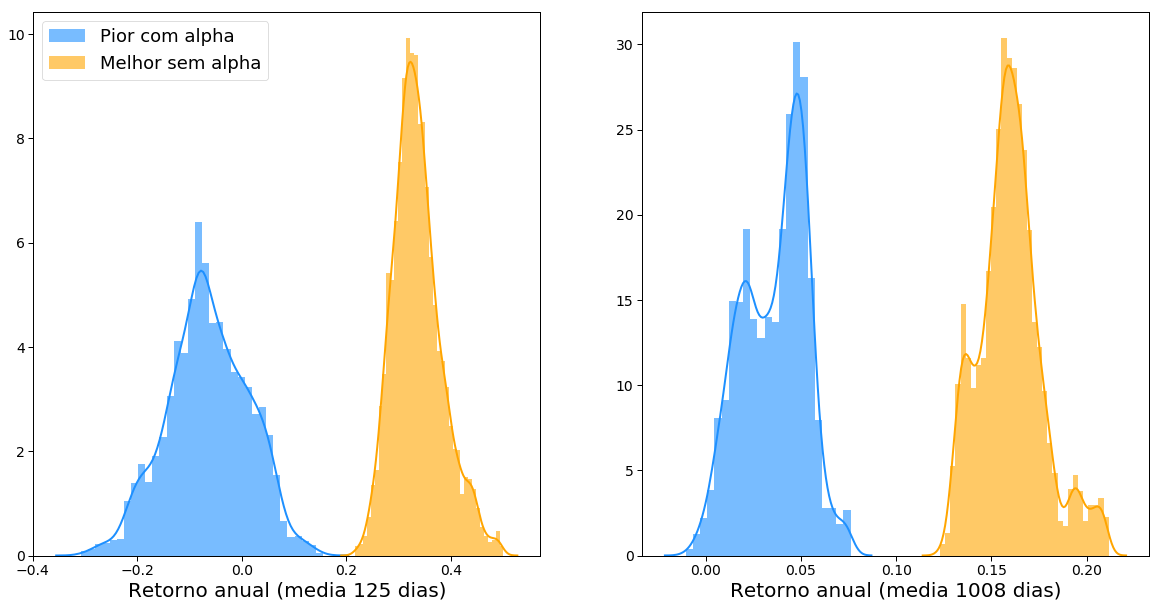

In [307]:
#================================================
# Melhor fundo ruim vs. media dos fundos bons
#================================================

minBons = np.zeros((nDays,len(nWin)))
topRuim = np.zeros((nDays,len(nWin)))

for i in range(len(nWin)):
    for j in range(nWin[i],nDays):
        meanAux = np.mean(retTs[(j-nWin[i]):(j+1),],axis=0)
        minBons[j,i]=np.min(meanAux[:nFundo])*252
        topRuim[j,i]=np.max(meanAux[nFundo:])*252
        
bonsShort = pd.DataFrame(list(minBons[nWin[0]:,0]))
ruimShort = pd.DataFrame(list(topRuim[nWin[0]:,0]))

bonsLong = pd.DataFrame(list(minBons[nWin[2]:,2]))
ruimLong = pd.DataFrame(list(topRuim[nWin[2]:,2]))

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["axes.labelsize"] = 30
plt.rcParams["font.size"] = 30

plt.subplot(1,2,1)
sns.distplot(bonsShort, color="dodgerblue", label="Pior com alpha", **kwargs)
sns.distplot(ruimShort, color="orange", label="Melhor sem alpha", **kwargs)
plt.xlabel('Retorno anual', fontsize=22)
plt.xlabel('Retorno anual (media '+str(nWin[0]) + ' dias)', fontsize=20)
plt.legend(fontsize=18);
plt.tick_params(labelsize=14);
plt.subplot(1,2,2)
sns.distplot(bonsLong, color="dodgerblue", label="Pior com alpha", **kwargs)
sns.distplot(ruimLong, color="orange", label="Melhor sem alpha", **kwargs)
plt.xlabel('Retorno anual (media '+str(nWin[2]) + ' dias)', fontsize=20)
plt.tick_params(labelsize=14);


In [205]:
#================================================
# Calcula carteira otima 
#================================================

import quadprog
ratio = np.zeros((nDays,len(nWin)))
muFoF = cdiDia + (sharpe*vol/252)/2

# Restriction
CAux = np.append(np.eye(nTot), -np.ones(nTot).reshape(nTot,1),axis=1)
a = np.zeros(nTot)
b = np.append(np.zeros(nTot),-1)
b = np.append(b,muFoF-mu)

for i in range(len(nWin)):
    for j in range(nWin[i],nDays):
        ret_ij = retTs[(j-nWin[i]):(j+1),]
        retCov = np.cov(ret_ij,rowvar =False)
        meanAux = np.mean(ret_ij,axis=0)
        C = np.append(CAux,(meanAux-mu).reshape(nTot,1),axis=1)
        res = quadprog.solve_qp(retCov,a,C,b)
        wVol = np.sqrt(res[1]*2*252)
        wOpt = res[0]
        ratio[j,i] = np.sum(wOpt[:nFundo])/np.sum(wOpt)   

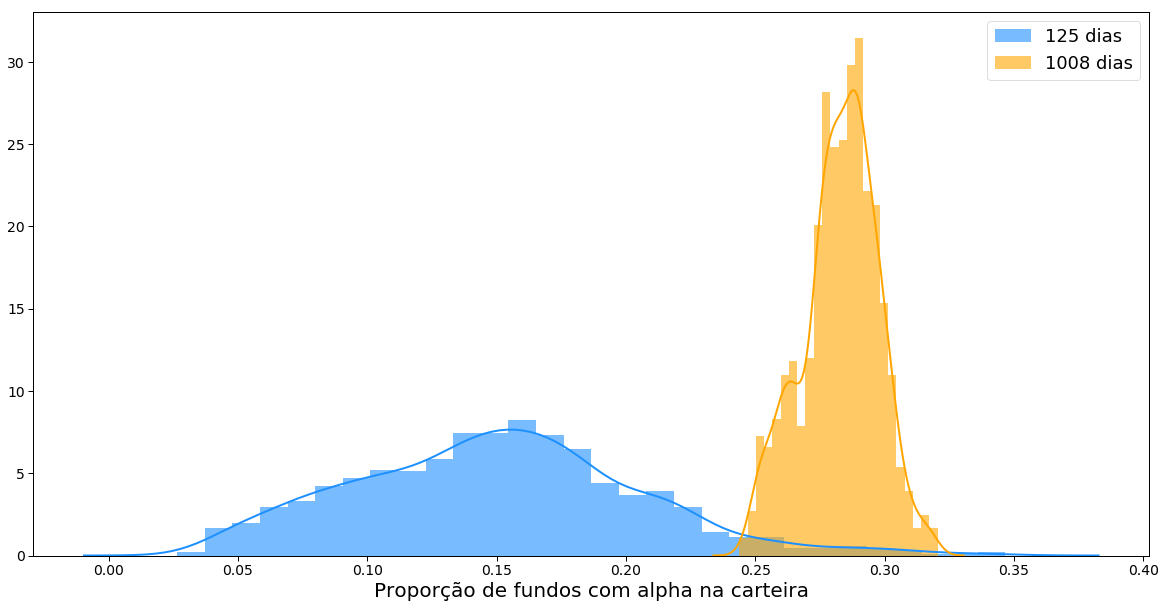

In [319]:
#================================================
# Melhor fundo ruim vs. media dos fundos bons
#================================================

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["axes.labelsize"] = 30
plt.rcParams["font.size"] = 30

sns.distplot(pd.DataFrame(ratio[nWin[0]:,0]), color="dodgerblue", label=str(nWin[0]) + " dias", **kwargs, norm_hist =True)
sns.distplot(pd.DataFrame(ratio[nWin[2]:,2]), color="orange", label=str(nWin[2]) + " dias", **kwargs, norm_hist  = True)
plt.xlabel('Proporção de fundos com alpha na carteira', fontsize=20)
plt.legend(fontsize=18);
plt.tick_params(labelsize=14);


In [176]:
#================================================
# Calcula fronteira eficiente - Estimada
#================================================

# Restriction
CAux = np.append(np.ones(nTot).reshape(nTot,1),np.eye(nTot), axis=1)
a = np.zeros(nTot)
bAux = np.append(1,np.zeros(nTot))

nRet = 100
retPlot = np.zeros((nRet,len(nWin)+1))
sigmaPlot = np.zeros((nRet,len(nWin)+1))
for i in range(len(nWin)+1):
    if i==len(nWin):
        retCov = np.eye(nTot)*sigma**2
        meanAux = np.append(np.ones(nFundo)*muAlpha,np.ones(nNoise)*mu)
        retMin = mu
        retMax = muAlpha 
    else:
        ret_ij = retTs[:nWin[i],]
        retCov = np.cov(ret_ij,rowvar =False)
        meanAux = np.mean(ret_ij,axis=0)
        retMin = np.percentile(meanAux,5)
        retMax = np.percentile(meanAux,95)
    
    C = np.append(meanAux.reshape(nTot,1),CAux,axis=1)
    
    for j in range(nRet):
        ret_j = retMin+j*(retMax-retMin)/nRet
        b = np.append(ret_j, bAux)
        res = quadprog.solve_qp(retCov,a,C,b,2)
        wVol = np.sqrt(res[1]*2*252)
        retPlot[j,i]=ret_j*252
        sigmaPlot[j,i]=wVol

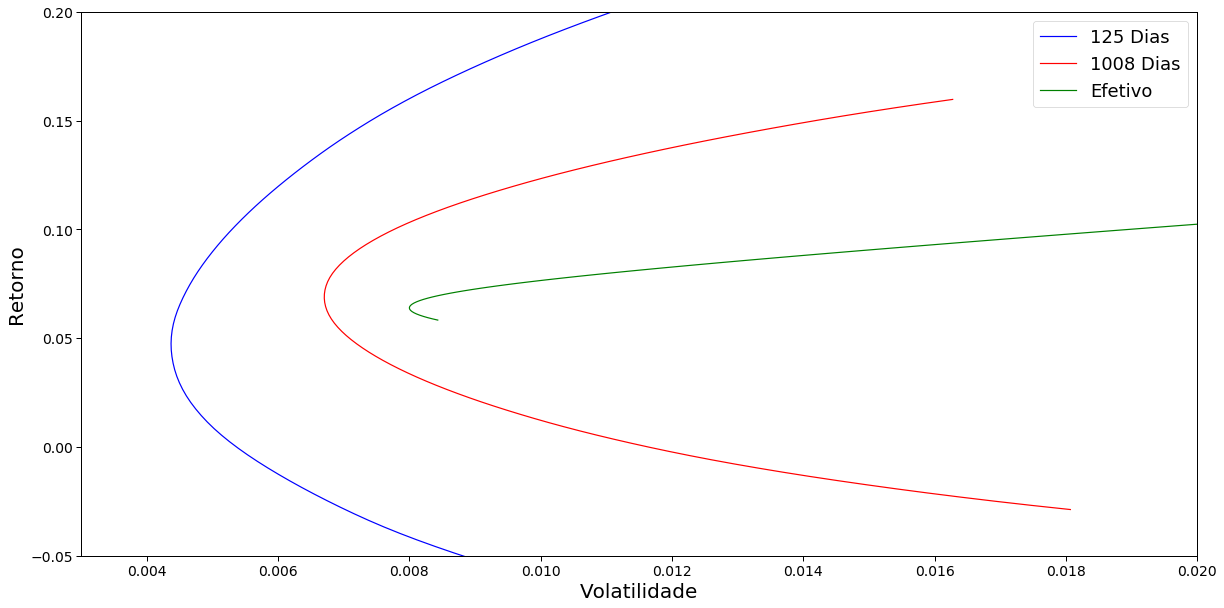

In [333]:
#================================================
# Plot fronteira
#================================================

plt.rcParams["figure.figsize"] = (20,10)

plt.axis([0.003, 0.02, -0.05, 0.2])
plt.plot(sigmaPlot[:,0],retPlot[:,0],color='blue',label = str(nWin[0])+" Dias")
plt.plot(sigmaPlot[:,2],retPlot[:,2],color='red', label = str(nWin[2])+" Dias")
plt.plot(sigmaPlot[:,4],retPlot[:,4],color='green', label = "Efetivo")

plt.xlabel('Volatilidade', fontsize=20)
plt.ylabel('Retorno', fontsize=20)
plt.legend(fontsize=18);
plt.tick_params(labelsize=14);

plt.show()

In [334]:
import os
os.getcwd()

'C:\\Users\\LE114190'